# Presentation : Conformal prediction implementation in River

- BOGGIO Richard
- MDIHI Samy
- VERON Marc

## Modules imports

Important to note that our custom modules have to be imported manually

In [83]:
# Existing in River
from river import datasets, metrics, stream
from river import tree, utils
from river import optim
from river import stats 
from river import preprocessing

# Not existing in River
import conf.ACP
import conf
import time_series
import time_series.evaluates
from time_series.holt_winters import HoltWinters
from time_series.AdHoeffTree_horizon import AdaptHoeffdingHorizon
from time_series.evaluates import _iter_with_horizon

# Other 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import timeit
import time
from scipy.stats import norm

Equivalent of norm.ppf in River : 

In [40]:
# Get a normal distribution
normal_dist = optim.initializers.Normal(mu=0, sigma=1, seed=42)
big_dist = normal_dist(shape=500000)

# confidence level
alpha = 0.975
# Compute with river
rolling_quantile = stats.Quantile(alpha)
for x in big_dist:
    _ = rolling_quantile.update(x)

# Check equivalence
print(f"with Scipy : {norm.ppf(alpha):.3f}")
print(f"with River : {rolling_quantile.get():.3f}")

with Scipy : 1.960
with River : 1.960


## Airline passengers dataset

In [41]:
dataset = datasets.AirlinePassengers()

## Defining the forecasting model

In [42]:
model = HoltWinters(
        alpha=0.3,
        beta=0.1,
        gamma=0.6,
        seasonality=12,
        multiplicative=True
        )

In [43]:
calib_period = 100
metric = metrics.MAE()
interval = conf.Gaussian(window_size=calib_period)

In [44]:
time_series.evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )


(+1  MAE: 39.432543
 +2  MAE: 38.132746
 +3  MAE: 37.370918
 +4  MAE: 37.74146
 +5  MAE: 37.968714
 +6  MAE: 38.922898
 +7  MAE: 42.079442
 +8  MAE: 42.828249
 +9  MAE: 47.111859
 +10 MAE: 48.481283
 +11 MAE: 50.429104
 +12 MAE: 50.401671,
 +1  (568.2561719334531, 209.15725662800554)
 +2  (625.7857065141985, 195.98726993814728)
 +3  (635.8580022730974, 142.52079701933621)
 +4  (695.0583720728821, 219.7299595434409)
 +5  (648.4961798093627, 241.3118097693339)
 +6  (645.6000896768649, 291.5140136476755)
 +7  (700.7480043748395, 376.14074767116597)
 +8  (799.5301010352644, 445.00400269826923)
 +9  (813.660475470789, 451.66571449287005)
 +10 (693.8838953645484, 346.09133989997235)
 +11 (655.2915484867885, 256.2480949498797)
 +12 (596.009046572053, 204.7156433398405))

In [45]:
dir(conf)

['ACP',
 'AdaptativeConformalPrediction',
 'Gaussian',
 'Interval',
 'RegressionJackknife',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'gaussian',
 'jackknife']

In [46]:
dir(time_series)

['ForecastingInterval',
 'ForecastingMetric',
 'HoltWinters',
 'HorizonAggMetric',
 'HorizonInterval',
 'HorizonMetric',
 'SNARIMAX',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_iter_with_horizon',
 'base',
 'evaluate',
 'evaluates',
 'get_iter_evaluate',
 'holt_winters',
 'intervals',
 'iter_evaluate',
 'metrics',
 'snarimax']

In [47]:
list_x, list_y, list_y_pred, list_metrics, list_interval = time_series.get_iter_evaluate(
        dataset,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )

In [48]:
list_interval

[+1  (574.4348500827209, 202.64878290489548)
 +2  (635.0572761013489, 181.65703483882308)
 +3  (647.2072923587391, 121.44984677914141)
 +4  (702.0708977163051, 196.5024250783469)
 +5  (649.5555957448332, 221.3163745356399)
 +6  (641.1652183814614, 274.7328299665779)
 +7  (692.3869241391278, 360.9658962012695)
 +8  (789.9512599064782, 430.2899401840349)
 +9  (804.5654842349389, 440.324827933012)
 +10 (687.7708278583027, 339.27117469264664)
 +11 (651.9495553795293, 250.82032629947372)
 +12 (594.9894453915466, 199.05140986945435),
 +1  (574.4348500827209, 202.64878290489548)
 +2  (635.0572761013489, 181.65703483882308)
 +3  (647.2072923587391, 121.44984677914141)
 +4  (702.0708977163051, 196.5024250783469)
 +5  (649.5555957448332, 221.3163745356399)
 +6  (641.1652183814614, 274.7328299665779)
 +7  (692.3869241391278, 360.9658962012695)
 +8  (789.9512599064782, 430.2899401840349)
 +9  (804.5654842349389, 440.324827933012)
 +10 (687.7708278583027, 339.27117469264664)
 +11 (651.9495553795293

## Electricity prices dataset

In [49]:
elec_prices = pd.read_csv("Prices_2016_2019_extract.csv", index_col=0, parse_dates=True)

In [50]:
elec_prices.tail(5)

,Spot,hour,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,lag_24_0,...,lag_168_15,lag_168_16,lag_168_17,lag_168_18,lag_168_19,lag_168_20,lag_168_21,lag_168_22,lag_168_23,conso
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,46.00,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,69600.0
2019-12-31 20:00:00,42.20,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,66000.0
2019-12-31 21:00:00,39.74,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,63600.0
2019-12-31 22:00:00,38.88,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,64800.0
2019-12-31 23:00:00,37.37,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26.06,...,26.97,27.72,33.41,36.51,34.03,30.0,28.93,23.61,20.99,67500.0


In [51]:
elec_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34896 entries, 2016-01-08 00:00:00 to 2019-12-31 23:00:00
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Spot        34896 non-null  float64
 1   hour        34896 non-null  float64
 2   dow_0       34896 non-null  float64
 3   dow_1       34896 non-null  float64
 4   dow_2       34896 non-null  float64
 5   dow_3       34896 non-null  float64
 6   dow_4       34896 non-null  float64
 7   dow_5       34896 non-null  float64
 8   dow_6       34896 non-null  float64
 9   lag_24_0    34896 non-null  float64
 10  lag_24_1    34896 non-null  float64
 11  lag_24_2    34896 non-null  float64
 12  lag_24_3    34896 non-null  float64
 13  lag_24_4    34896 non-null  float64
 14  lag_24_5    34896 non-null  float64
 15  lag_24_6    34896 non-null  float64
 16  lag_24_7    34896 non-null  float64
 17  lag_24_8    34896 non-null  float64
 18  lag_24_9    34896 non-null  flo

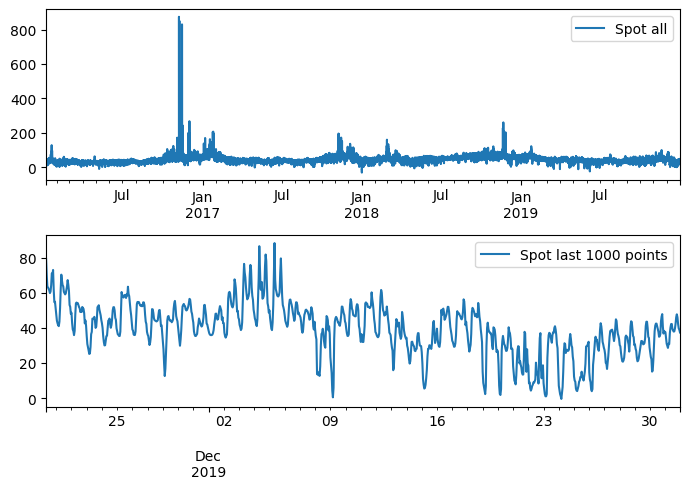

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7,5))
elec_prices[["Spot"]].plot(ax=ax1)
elec_prices[["Spot"]].iloc[-1000:,:].plot(ax=ax2)
ax1.xaxis.label.set_visible(False)
ax1.legend(["Spot all"])
ax2.xaxis.label.set_visible(False)
ax2.legend(["Spot last 1000 points"])
fig.tight_layout()

Defining the features X and the target label y

In [53]:
X, y = elec_prices.drop("Spot",axis=1), elec_prices[["Spot"]]

In [56]:
def run (model: time_series.base.Forecaster,
         stream_dataset, 
         metric=metrics.MAE(), 
         interval=conf.Gaussian(),
         horizon=1,
         step=1, 
         verbose=True
        ):
    """Run the model on the dataset, and return the prediction with interval

    Parameters
    ----------
    model : tree.HoeffdingAdaptiveTreeRegressor
        the tree model
    dataset : _type_
        _description_
    cache_key : _type_
        _description_
    step : int, optional
        _description_, by default 1
    verbose : bool, optional
        _description_, by default True

    Returns
    -------
    _type_
        _description_
    """
    start = time.time()   

    # Defining the metric for the horizon
    horizon_metric = time_series.HorizonMetric(metric)
    # Defining the interval for a certain horizon
    horizon_interval = time_series.HorizonInterval(interval)
    
    # Defining the receiving list to output
    list_y = []
    list_yh = []
    list_ypred = []
    list_metric = []
    list_interval = []
    i = 0

    ##############################################################################
    # Pre-train the model
    ##############################################################################

    # Initialize the dataset from the beginning to get the grace period
    steps = _iter_with_horizon(stream_dataset, horizon)

    # Pre train the model on a defined quantities of sample "grace_periode"
    # Set the grace period as the max between horizon and the interval.window_size
    grace_period = max(horizon, interval.window_size)

    # Go over the grace_period to fit the model
    for t in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        model.learn_one(y=y, x=x)  # type: ignore
        if t >= interval.window_size:
            break


    ##############################################################################
    # Get first residuals series with the pre-trained model
    ##############################################################################

    # Reinitialize the dataset from the beginning to get the grace period
    # And initialize the interval window
    # TODO : being able to predict_many. Would be easier
    steps = _iter_with_horizon(stream_dataset, horizon)
    for _ in range(grace_period):
        x, y, x_horizon, y_horizon = next(steps)
        # Get the residual that will be used for calibration
        # calibration predictions (subset of training points)
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Initializing the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)


    ##############################################################################
    # Forecast with intervals and learn
    ##############################################################################

    # No reinitialisation of the dataset since we begin from where we stopped 
    # at the pre-train stage
    i=0
    for x, y, x_horizon, y_horizon in steps:
        # Predicting future values until a certain horizon
        y_pred = model.forecast(horizon, xs=x_horizon)
        # Updating the metric
        horizon_metric.update(y_horizon, y_pred)
        # Updating the interval for each horizon
        horizon_interval.update(y_horizon, y_pred)
        # Train the model
        model.learn_one(y=y, x=x)  # type: ignore



        # Incremente the list of metric values
        if (i+1)%step==0:
            list_metric.append(horizon_metric.get())
            list_interval.append(horizon_interval.get())
            list_y.append(y)
            list_yh.append(y_horizon)
            list_ypred.append(y_pred)

            if verbose:
                print(f"{i+1} samples : full = {list_metric[-1][0]:0.2f}")
        i += 1
    end = time.time()
    print(f"\nStream passed in {end-start:.2f} seconds")
    return list_y, list_yh, list_ypred, list_metric, list_interval

In [79]:
steps_elec = stream.iter_csv("Prices_2016_2019_extract.csv",
                             target="Spot",
                             converters={"Spot": float},
                             parse_dates={"Date": "%Y-%m-%d %H:%M:%S"})

model = (
     preprocessing.StandardScaler() |
     tree.HoeffdingAdaptiveTreeRegressor(
        grace_period=200,
        max_depth=20,
        model_selector_decay=0.3,
        seed=0
        )
)


metric = metrics.MSE()

calib_period = 1000
interval = conf.CP.AdaptativeConformalPrediction(window_size=calib_period)

In [ ]:
time_series.evaluate(
        steps_elec,
        model,
        metric,
        interval,
        horizon=12,
        residual_calibration_period = calib_period
        )


In [80]:
list_y, list_yh, list_ypred, list_metric, list_interval = run(model, steps_elec, metric, interval)

1 samples : full = 7.47
2 samples : full = 7.25
3 samples : full = 12.56
4 samples : full = 13.37
5 samples : full = 11.89
6 samples : full = 13.73
7 samples : full = 13.24
8 samples : full = 11.59
9 samples : full = 11.27
10 samples : full = 14.31
11 samples : full = 15.26
12 samples : full = 14.59
13 samples : full = 15.49
14 samples : full = 15.19
15 samples : full = 14.89
16 samples : full = 14.93
17 samples : full = 14.31
18 samples : full = 13.52
19 samples : full = 12.81
20 samples : full = 12.28
21 samples : full = 15.53
22 samples : full = 25.18
23 samples : full = 29.34
24 samples : full = 28.61
25 samples : full = 27.93
26 samples : full = 27.37
27 samples : full = 26.58
28 samples : full = 25.88
29 samples : full = 25.53
30 samples : full = 25.55
31 samples : full = 25.23
32 samples : full = 24.77
33 samples : full = 24.84
34 samples : full = 24.39
35 samples : full = 24.36
36 samples : full = 23.76
37 samples : full = 23.27
38 samples : full = 23.09
39 samples : full = 22.

In [61]:
# Transform in array
arr_interval = np.asarray(list_interval)
arr_metrics = np.asarray(list_metric)
arr_ypred = np.asarray(list_ypred)
arr_yh = np.asarray(list_yh)
arr_y = np.asarray(list_y)

print(arr_interval.shape)
print(arr_metrics.shape)
print(arr_ypred.shape)
print(arr_yh.shape)
print(arr_y.shape)

(32894, 1, 2)
(32894, 1)
(32894, 1)
(32894, 1)
(32894,)


[]

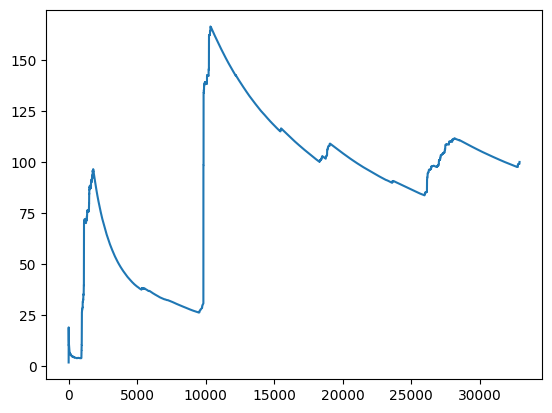

In [62]:
plt.plot(arr_metrics[:,0])
plt.plot()

In [71]:
arr_interval[:10].squeeze(1)

array([[ 7.47651815, 65.19469748],
       [15.47408495, 68.98636859],
       [35.50348619, 83.53850866],
       [       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf],
       [       -inf,         inf]])

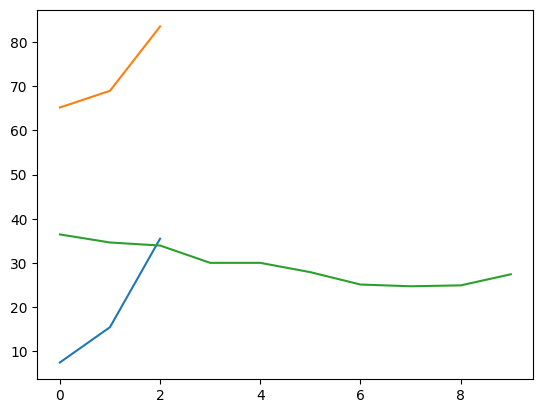

In [72]:
plt.plot(arr_interval[:10].squeeze(1))
plt.plot(arr_y[:10])
plt.show()

NameError: name 'ci' is not defined

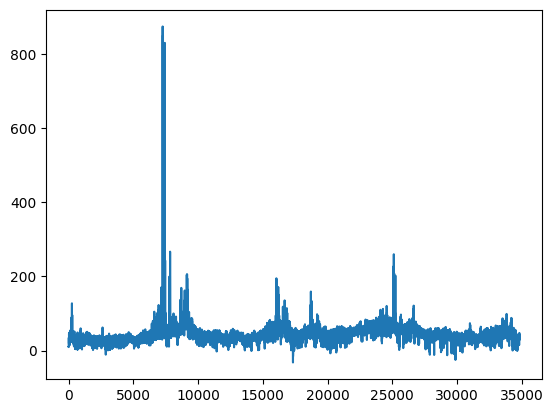

In [26]:
fig, ax = plt.subplots()
ax.plot(arr_y)
ax.fill_between((y-ci), (y+ci), color='b', alpha=.1)

In [ ]:
tab_gamma = [0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]